In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

In [2]:
def assemble_predictors_predictands(start_date, end_date, lead_time, dataset, num_input_time_steps):
    '''
    Args
    ----

    start_date (str): The start date for extraction. Important, put the trailing 0 at the beginning of year for dates before 1000 (e.g., '0400')
    end_date (str): The end date for extraction
    lead_time (int): The number of months between the predictor/predictand
    dataset (str): Either 'CESM' or 'ECMWF'
    num_input_time_steps (int): The number of time steps to use for each predictor samples

    '''    

    file_name = {'CESM': 'CESM_EA_SPI.nc', 'ECMWF': 'ECMWF_EA_SPI.nc'}[dataset]

    ds = xr.open_dataset(file_name)
    spi = ds['spi'].sel(time=slice(start_date,end_date))

    num_samples=spi.shape[0]

    #Stack and remove nans
    spi = np.stack([spi.values[n-num_input_time_steps:n] for n in range(num_input_time_steps, num_samples+1)])
    num_samples = spi.shape[0]
    spi[np.isnan(spi)] = 0

    #make sure we have floats in there
    X = spi.astype(np.float32)

    # select Y
    if dataset == 'ECMWF':
        start_date_plus_lead = pd.to_datetime(start_date) + pd.DateOffset(months=lead_time+num_input_time_steps-1)
        end_date_plus_lead = pd.to_datetime(end_date) + pd.DateOffset(months=lead_time)

    elif dataset == 'CESM':
        t_start=datetime.datetime(int(start_date.split('-')[0]),int(start_date.split('-')[1]),int(start_date.split('-')[2]))
        t_end=datetime.datetime(int(end_date.split('-')[0]),int(end_date.split('-')[1]),int(end_date.split('-')[2]))
        start_date_plus_lead = t_start + relativedelta(months=lead_time+num_input_time_steps-1)
        end_date_plus_lead = t_end + relativedelta(months=lead_time)
        #target_start_date_with_2_month = start_date_plus_lead - relativedelta(months=2)
        if len(str(start_date_plus_lead.year))<4:
            start_date_plus_lead = '0'+start_date_plus_lead.strftime('%Y-%m-%d')
        elif len(str(start_date_plus_lead.year))==4:
            start_date_plus_lead = start_date_plus_lead.strftime('%Y-%m-%d')
        if len(str(end_date_plus_lead.year))<4:
            end_date_plus_lead = '0'+end_date_plus_lead.strftime('%Y-%m-%d')
        elif len(str(end_date_plus_lead.year))==4:
            end_date_plus_lead = end_date_plus_lead.strftime('%Y-%m-%d')

    subsetted_ds = ds['spi'].sel(time=slice(start_date_plus_lead,
                                                 end_date_plus_lead))
    f = subsetted_ds. values.astype(np.float32)
    f[np.isnan(f)] = 0
    ds.close()

    return X,f

class SPIDataset(Dataset):
    def __init__(self, predictors, predictands):
        self.predictors = predictors
        self.predictands = np.expand_dims(predictands, axis=1)
        assert self.predictors.shape[0] == self.predictands.shape[0], \
                   "The number of predictors must equal the number of predictands!"

    def __len__(self):
        return self.predictors.shape[0]

    def __getitem__(self, idx):
        return self.predictors[idx], self.predictands[idx]

In [3]:
class CNN(nn.Module):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_input_time_steps, out_channels=6,  kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,  kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=42,  kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=42, out_channels=1,  kernel_size=3, padding=1)
        self.print_layer = Print()
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        if self.print_feature_dimension:
            x = self.print_layer(x)
        x = self.conv4(x)
        return x

class Print(nn.Module):
    """
    This class prints out the size of the features
    """
    def forward(self, x):
        print(x.size())
        return x

In [4]:
def train_network(net, criterion, optimizer, trainloader, testloader, experiment_name, num_epochs=40):
    """
    inputs
    ------

      net               (nn.Module)   : the neural network architecture
      criterion         (nn)          : the loss function (i.e. root mean squared error)
      optimizer         (torch.optim) : the optimizer to use update the neural network 
                                        architecture to minimize the loss function
      trainloader       (torch.utils.data.DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the train dataset
      testloader        (torch.utils.data. DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the test dataset
      experiment_name   Name of the experiment (for visualization purposes)
      num_epochs        Number of epochs (default=40)


    outputs
    -------
      predictions (np.array), and saves the trained neural network as a .pt file
    """
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    net = net.to(device)
    best_loss = np.infty
    train_losses, test_losses = [], []

    for epoch in range(num_epochs):
        for mode, data_loader in [('train', trainloader), ('test', testloader)]:
            #Set the model to train mode to allow its weights to be updated
            #while training
            if mode == 'train':
                net.train()

            #Set the model to eval model to prevent its weights from being updated
            #while testing
            elif mode == 'test':
                net.eval()

            running_loss = 0.0
            for i, data in enumerate(data_loader):
                # get a mini-batch of predictors and predictands
                batch_predictors, batch_predictands = data
                batch_predictands = batch_predictands.to(device)
                batch_predictors = batch_predictors.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                #calculate the predictions of the current neural network
                predictions = net(batch_predictors)

                #quantify the quality of the predictions using a
                #loss function (aka criterion) that is differentiable
                loss = criterion(predictions, batch_predictands)

                if mode == 'train':
                    #the 'backward pass: calculates the gradients of each weight
                    #of the neural network with respect to the loss
                    loss.backward()

                    #the optimizer updates the weights of the neural network
                    #based on the gradients calculated above and the choice
                    #of optimization algorithm
                    optimizer.step()

                #Save the model weights that have the best performance!
                running_loss += loss.item()
                if running_loss < best_loss and mode == 'test':
                    best_loss = running_loss
                    torch.save(net.state_dict(), '{}.pt'.format(experiment_name))
            print('{} Set: Epoch {:02d}. loss: {:3f}'.format(mode, epoch+1, running_loss/len(data_loader)))
            if mode == 'train':
                train_losses.append(running_loss/len(data_loader))
            else:
                test_losses.append(running_loss/len(data_loader))
    return train_losses, test_losses

In [5]:
def test_network(testloader,experiment_name,num_input_time_steps):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    net = CNN(num_input_time_steps,False)
    net.load_state_dict(torch.load('{}.pt'.format(experiment_name)))
    net.eval()
    net.to(device)

    #the remainder of this notebook calculates the predictions of the best
    #saved model
    for i, data in enumerate(testloader):
        batch_predictors, batch_predictands = data
        batch_predictands = batch_predictands.to(device)
        batch_predictors = batch_predictors.to(device)

        batch_predictions = net(batch_predictors).squeeze()
        batch_predictions = batch_predictions.detach().cpu().numpy()
        try:   
            predictions = np.vstack((predictions, batch_predictions))
        except NameError:
            predictions = batch_predictions
        return predictions

In [6]:
##Parameters
num_input_time_steps = 3 
lead_time = 3

num_epochs = 100

climate_model = 'CESM'
train_start_date = '0400-01-01'
train_end_date = '1800-12-31'

test_start_date = '1801-01-01'
test_end_date = '1978-12-31'

In [7]:
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date, train_end_date, lead_time, climate_model, num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands(test_start_date, test_end_date, lead_time, climate_model,num_input_time_steps)

#Convert the numpy ararys into ENSODataset, which is a subset of the 
#torch.utils.data.Dataset class.  This class is compatible with
#the torch dataloader, which allows for data loading for a CNN
train_dataset = SPIDataset(train_predictors, train_predictands)
test_dataset = SPIDataset(test_predictors, test_predictands)

#Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
#the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=100)
testloader = DataLoader(test_dataset, batch_size=100)
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.00001)

experiment_name = "threelayerCNN_{}_{}_{}".format(train_start_date, train_end_date,lead_time)
train_losses, test_losses = train_network(net, nn.MSELoss(), optimizer, trainloader, testloader, experiment_name, num_epochs)
predictions = test_network(testloader,experiment_name,num_input_time_steps)

train Set: Epoch 01. loss: 0.984806
test Set: Epoch 01. loss: 1.033687
train Set: Epoch 02. loss: 0.962742
test Set: Epoch 02. loss: 1.003473
train Set: Epoch 03. loss: 0.927999
test Set: Epoch 03. loss: 0.956436
train Set: Epoch 04. loss: 0.880773
test Set: Epoch 04. loss: 0.901926
train Set: Epoch 05. loss: 0.834239
test Set: Epoch 05. loss: 0.857340
train Set: Epoch 06. loss: 0.802458
test Set: Epoch 06. loss: 0.831040
train Set: Epoch 07. loss: 0.784014
test Set: Epoch 07. loss: 0.815098
train Set: Epoch 08. loss: 0.771811
test Set: Epoch 08. loss: 0.804307
train Set: Epoch 09. loss: 0.763269
test Set: Epoch 09. loss: 0.796932
train Set: Epoch 10. loss: 0.757236
test Set: Epoch 10. loss: 0.791715
train Set: Epoch 11. loss: 0.752739
test Set: Epoch 11. loss: 0.787744
train Set: Epoch 12. loss: 0.749135
test Set: Epoch 12. loss: 0.784487
train Set: Epoch 13. loss: 0.746067
test Set: Epoch 13. loss: 0.781628
train Set: Epoch 14. loss: 0.743327
test Set: Epoch 14. loss: 0.779069
train 

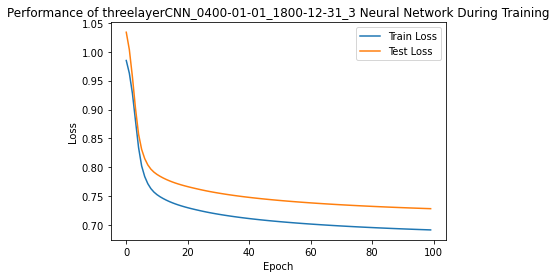

In [8]:
#Look at learning curves
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()